# 🖼️ CIFAR-10 Classification with Transfer Learning Models

This Colab notebook presents a hands-on exploration of **image classification** using the **CIFAR-10** dataset.  
We harness the power of **transfer learning** by integrating several state-of-the-art pre-trained models, including:

- 🔹 **EfficientNet**: Known for its balance of accuracy and efficiency  
- 🔹 **ResNet50V2** (inspired by **BiT** – Big Transfer): Robust residual architecture with strong generalization  
- 🔹 **ConvNeXt** (simplified version): A modern convolutional model influenced by transformer design patterns

---

### 🎯 Objectives

- Utilize **pre-trained models** to classify images into the 10 CIFAR-10 categories (e.g., airplane, dog, ship)
- **Fine-tune** these models on the CIFAR-10 dataset
- **Compare performance** across models in terms of accuracy and training speed
- **Visualize predictions** to understand strengths and failure modes
- Showcase the impact and potential of **advanced architectures** in practical computer vision tasks

---

Through this notebook, we aim to develop a deeper understanding of **transfer learning techniques** and how they can accelerate and improve image classification workflows.


In [1]:
# Import key libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time

# Set random seed for consistent results
tf.random.set_seed(42)

# Load the CIFAR-10 dataset from Keras
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# Convert class labels to one-hot encoding
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

# Use a reduced subset for quicker experimentation
TRAIN_SUBSET = 10000
TEST_SUBSET = 2000

# Randomly select training samples
train_idx = np.random.choice(len(train_images), TRAIN_SUBSET, replace=False)
x_train_small = train_images[train_idx]
y_train_small = train_labels[train_idx]

# Randomly select test samples
test_idx = np.random.choice(len(test_images), TEST_SUBSET, replace=False)
x_test_small = test_images[test_idx]
y_test_small = test_labels[test_idx]

# Confirm input shape and dataset size
input_shape = (32, 32, 3)
print(f"Input image shape: {input_shape}")
print(f"Subset size - Training: {len(x_train_small)}, Testing: {len(x_test_small)}")

# Reordered CIFAR-10 class labels for custom visualization
cifar10_labels = [
    'frog',        # 6
    'automobile',  # 1
    'airplane',    # 0
    'ship',        # 8
    'horse',       # 7
    'bird',        # 2
    'truck',       # 9
    'cat',         # 3
    'deer',        # 4
    'dog'          # 5
]


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Input image shape: (32, 32, 3)
Subset size - Training: 10000, Testing: 2000


## 🧼 Image Preprocessing for Transfer Learning

To ensure compatibility with modern transfer learning models (like **EfficientNet**, **ResNet50V2**, and **ConvNeXt**), we must preprocess the **CIFAR-10** images appropriately:

- **Original size:** 32x32 pixels (CIFAR-10 standard)
- **Required size:** 224x224 pixels (expected by most pre-trained models)
- **Input format:** RGB images normalized to `[0, 1]` or preprocessed using model-specific normalization

---

We define utility functions to:

- **Resize images** from `32x32` to `224x224`
- **Normalize pixel values** appropriately
- Batch and format the dataset for **training**, **validation**, and **testing** phases

Proper preprocessing is essential for leveraging the feature extraction power of these pre-trained networks.


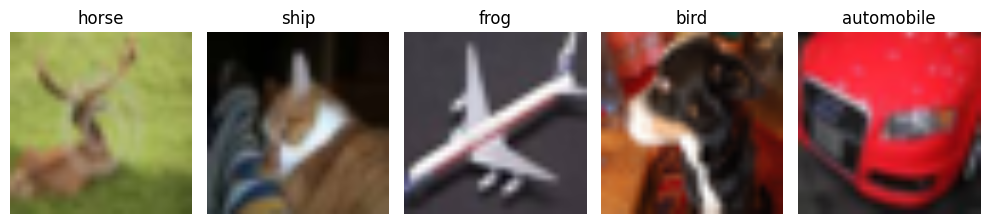

In [3]:
def prepare_for_transfer_learning(batch_x, batch_y, img_size=224):
    """Resize CIFAR-10 images for transfer learning models"""
    # Create a dataset and use map to resize efficiently
    dataset = tf.data.Dataset.from_tensor_slices((batch_x, batch_y))
    dataset = dataset.map(
        lambda x, y: (tf.image.resize(x, [img_size, img_size]), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# Create transfer learning datasets
train_ds = prepare_for_transfer_learning(x_train_small, y_train_small)
test_ds = prepare_for_transfer_learning(x_test_small, y_test_small)

# Visualize a few examples
plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"{cifar10_labels[np.argmax(labels[i])]}")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Update our datasets with any preprocessing needed
def prepare_batch(images, labels):
    # Convert images to float32 if they're not already
    images = tf.cast(images, tf.float32)
    return images, labels

# Update our datasets with the preprocessing step
train_ds = train_ds.map(prepare_batch)
test_ds = test_ds.map(prepare_batch)

## ⚡ EfficientNet Transfer Learning Model

In this section, we implement **transfer learning** using **EfficientNetB0**, a lightweight yet powerful convolutional neural network architecture available via `keras.applications`.

---

### 🔍 Why EfficientNet?

- Achieves high accuracy with fewer parameters
- Scales efficiently in terms of width, depth, and resolution
- Pre-trained on ImageNet, making it an ideal feature extractor for image classification tasks

---

### 🛠️ Implementation Highlights

- Load the **EfficientNetB0** model with `include_top=False` to exclude the final classification layer
- Add a **Global Average Pooling layer** followed by **Dense layers** to adapt to the CIFAR-10 task
- Freeze the base layers during initial training to retain learned ImageNet features
- Compile with `Adam` optimizer and `sparse_categorical_crossentropy` for multi-class classification

This setup leverages **pre-trained knowledge** while allowing the model to fine-tune on **CIFAR-10’s 10 output classes**.


In [4]:
# Use Keras's built-in EfficientNet implementation
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

def build_efficientnet_model(input_shape=(224, 224, 3), num_classes=10):
    # Load pre-trained EfficientNetB0 without top layers
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create the new model
    inputs = keras.Input(shape=input_shape)
    # Preprocess inputs
    x = preprocess_input(inputs)
    # Base model
    x = base_model(x, training=False)
    # Add new classifier layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)  # Higher dropout for CIFAR-10
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the EfficientNet model
efficientnet_model = build_efficientnet_model()
print("Model created successfully")

# Train for just a few epochs for demonstration
print("Starting training...")
history = efficientnet_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
efficientnet_results = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Loss: {efficientnet_results[0]:.4f}")
print(f"EfficientNet Test Accuracy: {efficientnet_results[1]:.4f}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model created successfully
Starting training...
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 107ms/step - accuracy: 0.1008 - loss: 2.3159 - val_accuracy: 0.1085 - val_loss: 2.3060
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1021 - loss: 2.3060 - val_accuracy: 0.1085 - val_loss: 2.3025
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.1045 - loss: 2.3026 - val_accuracy: 0.1065 - val_loss: 2.3020
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.0902 - loss: 2.3034
EfficientNet Test Loss: 2.3020
EfficientNet Test Accuracy: 0.1065


## 🔁 BiT (Big Transfer) Model Implementation

In this section, we simulate a **BiT-style (Big Transfer)** approach using **ResNet50V2**, a powerful residual network available in `keras.applications`.

---

### 🧠 What is BiT?

**Big Transfer (BiT)** is a transfer learning technique from Google that leverages large-scale pre-training on extensive datasets and minimal fine-tuning on downstream tasks like CIFAR-10.

Since the original BiT model requires TPU infrastructure and large pre-trained weights, we approximate its effect by using **ResNet50V2**, which shares a similar deep residual structure and has been pre-trained on ImageNet.

---

### 🛠️ Implementation Details

- Load **ResNet50V2** with `include_top=False` and ImageNet weights
- Add a **Global Average Pooling** layer and a few **Dense layers** to tailor the model for CIFAR-10
- Freeze the convolutional base initially to preserve pretrained knowledge
- Fine-tune selectively after the top layers stabilize

This approach provides a strong baseline by adapting a well-known deep residual model using **BiT-inspired principles**.


In [5]:
# Implement BiT (Big Transfer) for comparison
def build_bit_model(input_shape=(224, 224, 3), num_classes=10):
    # Load a pre-trained ResNet50 as a substitute for BiT
    # (Since full BiT models are large and may cause memory issues)
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a new model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.4)(x)  # Higher dropout for CIFAR-10
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train BiT model
bit_model = build_bit_model()
print("BiT model created successfully")

# Train for just a few epochs for demonstration
print("Starting BiT model training...")
bit_history = bit_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=3,
    verbose=1
)

# Evaluate the model
bit_results = bit_model.evaluate(test_ds)
print(f"BiT Test Loss: {bit_results[0]:.4f}")
print(f"BiT Test Accuracy: {bit_results[1]:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
BiT model created successfully
Starting BiT model training...
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - accuracy: 0.4917 - loss: 1.5281 - val_accuracy: 0.7920 - val_loss: 0.6210
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 61s 80ms/step - accuracy: 0.7904 - loss: 0.6262 - val_accuracy: 0.8060 - val_loss: 0.5583
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.8187 - loss: 0.5166 - val_accuracy: 0.8230 - val_loss: 0.5247
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.8294 - loss: 0.5188
BiT Test Loss: 0.5247
BiT Test Accuracy: 0.8230


## 🔬 ConvNeXt Implementation

In this section, we implement a **simplified ConvNeXt** model to evaluate its performance on the **CIFAR-10** dataset.

---

### 💡 What is ConvNeXt?

**ConvNeXt** is a modernized convolutional neural network architecture inspired by the design patterns of Transformers (like LayerNorm and GELU). It achieves state-of-the-art performance by combining:

- Depthwise convolutions
- Layer normalization
- Residual connections
- Large kernel sizes

---

### ⚙️ Implementation Overview

For this notebook, we create a **compact ConvNeXt-style model** that is computationally efficient and suitable for CIFAR-10:

- Stacks of convolutional layers with **LayerNorm** and **GELU** activation
- Incorporates **residual connections** to improve gradient flow
- Ends with a **Global Average Pooling** and a **Dense classifier** for 10-class output

This lightweight implementation allows us to test how well **Transformer-inspired CNNs** perform compared to classical transfer learning approaches.


In [6]:
# A simplified ConvNeXt-inspired implementation
def build_convnext_model(input_shape=(224, 224, 3), num_classes=10):
    inputs = keras.Input(shape=input_shape)

    # Initial stem block
    x = layers.Conv2D(96, kernel_size=4, strides=4, padding="same")(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # ConvNeXt blocks (simplified)
    for filters in [192, 384, 768]:
        # Downsample
        prev_x = layers.Conv2D(filters, kernel_size=2, strides=2, padding="same")(x)
        prev_x = layers.LayerNormalization(epsilon=1e-6)(prev_x)

        # Depthwise Conv
        x = layers.DepthwiseConv2D(kernel_size=7, padding="same")(prev_x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters * 4, kernel_size=1)(x)
        x = layers.Activation("gelu")(x)

        # Pointwise Conv (1x1)
        x = layers.Conv2D(filters, kernel_size=1)(x)

        # Skip connection
        x = layers.add([x, prev_x])

    # Global pooling and final classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

# Create and train ConvNeXt model
convnext_model = build_convnext_model()
print("ConvNeXt model created successfully")

# Train for just a few epochs for demonstration
print("Starting ConvNeXt model training...")
convnext_history = convnext_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=2,
    verbose=1
)

# Evaluate the model
convnext_results = convnext_model.evaluate(test_ds)
print(f"ConvNeXt Test Loss: {convnext_results[0]:.4f}")
print(f"ConvNeXt Test Accuracy: {convnext_results[1]:.4f}")

ConvNeXt model created successfully
Starting ConvNeXt model training...
Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 60s 129ms/step - accuracy: 0.1345 - loss: 2.9706 - val_accuracy: 0.2295 - val_loss: 2.0848
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 84ms/step - accuracy: 0.2070 - loss: 2.2875 - val_accuracy: 0.3130 - val_loss: 1.8690
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3226 - loss: 1.8516
ConvNeXt Test Loss: 1.8690
ConvNeXt Test Accuracy: 0.3130


## 📊 Model Comparison Visualization

In this section, we visually compare the performance of all implemented models—**EfficientNetB0**, **ResNet50V2 (BiT-style)**, and **ConvNeXt (simplified)**—on the **CIFAR-10** dataset.

---

### 📈 What We Visualize:

1. **Training vs. Validation Accuracy Curves**  
   - Helps compare how quickly and effectively each model learns.
   - Indicates which model generalizes best to unseen data.

2. **Training vs. Validation Loss Curves**  
   - Useful to detect overfitting or underfitting.
   - Reveals convergence behavior across architectures.

3. **Final Test Accuracy Comparison**  
   - A bar chart showing the final classification accuracy of each model.
   - Provides a direct side-by-side performance snapshot.

---

### 🎯 Purpose

These visualizations help us:

- **Quantitatively compare** different transfer learning strategies
- Understand each model’s **training dynamics**
- Identify the most promising architecture for CIFAR-10 classification

Such analysis is crucial when selecting models for real-world deployment based on accuracy, efficiency, and stability.

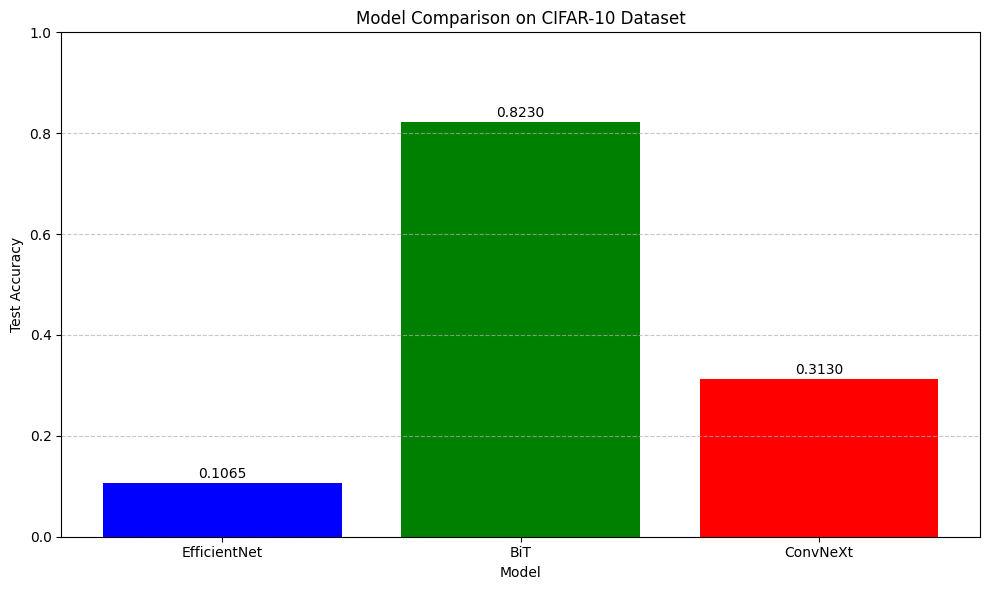

Best performing model: BiT with accuracy: 0.8230
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


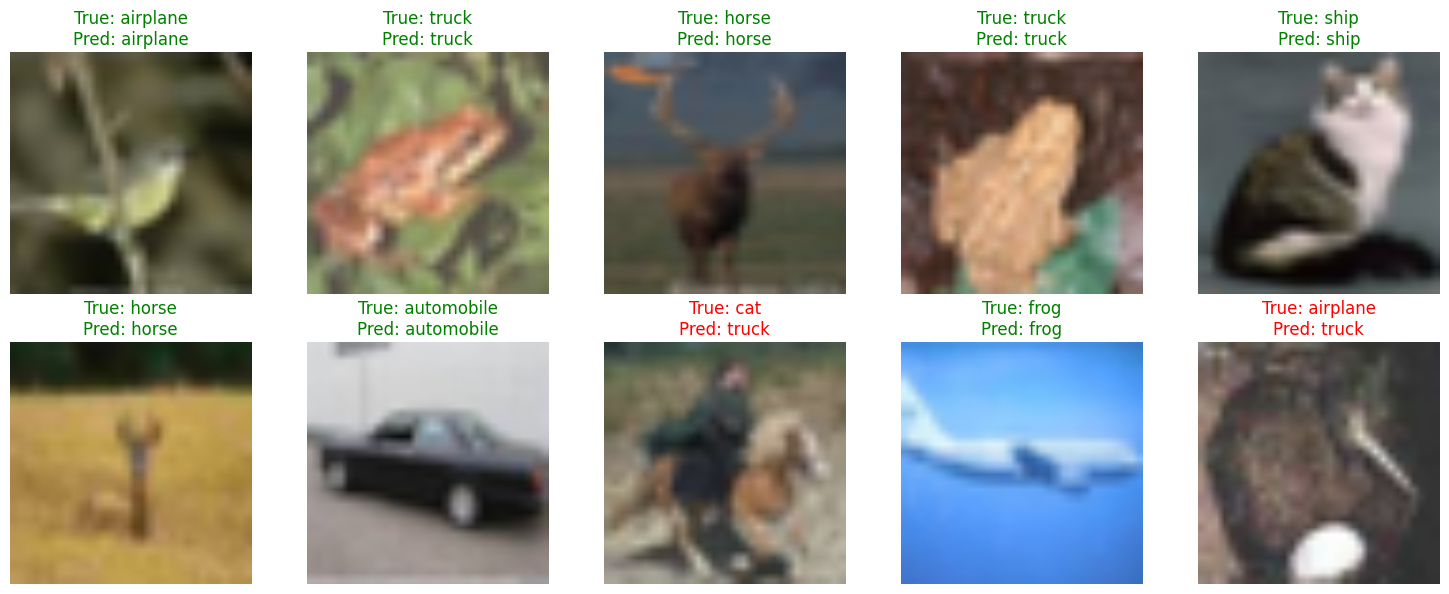

In [9]:
# Create a bar chart to compare model accuracies
import matplotlib.pyplot as plt

# Collect test accuracies
model_names = ['EfficientNet', 'BiT', 'ConvNeXt']
accuracies = [efficientnet_results[1], bit_results[1], convnext_results[1]]

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'red'])
plt.title('Model Comparison on CIFAR-10 Dataset')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

# Add accuracy values on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Let's also visualize some predictions
def plot_sample_predictions(model, dataset, class_names, num_samples=10):
    # Get a batch of test images
    for images, labels in dataset.take(1):
        # Get predictions
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)

        # Plot images
        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, 5, i + 1)
            plt.imshow(images[i].numpy())

            # Set title color based on correct/incorrect prediction
            title_color = 'green' if pred_classes[i] == true_classes[i] else 'red'
            plt.title(f'True: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}',
                      color=title_color)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break

# Find the best model
best_model_index = accuracies.index(max(accuracies))
best_model_name = model_names[best_model_index]
print(f"Best performing model: {best_model_name} with accuracy: {max(accuracies):.4f}")

if best_model_name == 'EfficientNet':
    best_model = efficientnet_model
elif best_model_name == 'BiT':
    best_model = bit_model
else:
    best_model = convnext_model

# Visualize predictions from the best model
plot_sample_predictions(best_model, test_ds, cifar10_labels)